In [2]:
import fedfred as fd
import pandas as pd

api_key = '60d859111bd990fa19befefab09812ea'
fred = fd.FredAPI(api_key)

# Define series IDs and their desired names
series_map = {
    'GDP': 'gdp',                 # Gross Domestic Product
    'TB3MS': 'tbill_3m',              # 3-Month Treasury Bill Secondary Market Rate
    'GS1': 'tbill_1y',                 # 1-Year Treasury Constant Maturity Rate
    'GS10': 'tbill_10y',               # 10-Year Treasury Constant Maturity Rate
    'DGS30': 'tbill_30y',              # 30-Year Treasury Constant Maturity Rate
    'CPIAUCSL': 'cpi',            # Consumer Price Index for All Urban Consumers
    'UMCSENT': 'cons_sentiment',       # University of Michigan: Consumer Sentiment
    'UNRATE': 'unemployment',           # Civilian Unemployment Rate
    'BAA10Y': 'corp_bond_spread', # Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
    'DRCCLACBS': 'household_delinq', # Delinquency Rate on Credit Card Loans, All Commercial Banks
    # SP500: From Yahoo Finance
    'VIXCLS': 'vix'            # CBOE Volatility Index
}

# Fetch data for all series
all_data = {}
for series_id, name in series_map.items():
    # Determine aggregation method (only needed for non-quarterly sources)
    agg_method = 'avg' if series_id not in ['GDP'] else None
    try:
        data = fred.get_series_observations(series_id, frequency='q', aggregation_method=agg_method)
        # Select only the 'value' column and rename it
        all_data[name] = data[['value']].rename(columns={'value': name})
        print(f"Fetched {name} data.")
    except Exception as e:
        print(f"Could not fetch data for {series_id} ({name}): {e}")

# Combine all dataframes into one using the index (date)
# Start with GDP and left-join the others
if 'gdp' in all_data:
    combined_df = all_data.pop('gdp')
    for name, df in all_data.items():
        combined_df = pd.merge(combined_df, df, left_index=True, right_index=True, how='left')

    print("\nCombined DataFrame (Tail):")
    print(combined_df.tail())

    print("\nCombined DataFrame Info:")
    print(combined_df.info())
else:
    print("\nGDP data could not be fetched. Cannot create combined DataFrame.")


# Save the combined DataFrame to parquet
combined_df.to_parquet('macro_data_raw.parquet', index=True)


Fetched gdp data.
Fetched tbill_3m data.
Fetched tbill_1y data.
Fetched tbill_10y data.
Fetched tbill_30y data.
Fetched cpi data.
Fetched cons_sentiment data.
Fetched unemployment data.
Fetched corp_bond_spread data.
Fetched household_delinq data.
Fetched vix data.

Combined DataFrame (Tail):
                  gdp  tbill_3m  tbill_1y  tbill_10y  tbill_30y      cpi  \
date                                                                       
2024-01-01  28624.069      5.23      4.90       4.16       4.33  310.974   
2024-04-01  29016.714      5.24      5.14       4.44       4.58  313.096   
2024-07-01  29374.914      4.99      4.45       3.95       4.23  314.183   
2024-10-01  29723.864      4.40      4.25       4.28       4.49  316.539   
2025-01-01  29977.632      4.21      4.14       4.45       4.71  319.492   

            cons_sentiment  unemployment  corp_bond_spread  household_delinq  \
date                                                                           
2024-01-01   

# Transform the data

In [4]:
if not combined_df.empty:
    print("\nApplying transformations...")
    transformed_df = combined_df.copy() # Work on a copy

    # --- 1. Percentage change ---
    for col in ['gdp', 'cpi', 'cons_sentiment', 'vix']:
        if col in transformed_df.columns:
            # QoQ % Change
            transformed_df[f'{col}_qoq'] = transformed_df[col].pct_change(periods=1)
            # YoY % Change
            transformed_df[f'{col}_yoy'] = transformed_df[col].pct_change(periods=4) 
        else:
            print(f"Column {col} not found in DataFrame. Skipping...")

    # --- 2. Percentages divided by 100 ---
    rate_cols = ['tbill_3m', 'tbill_1y', 'tbill_10y', 'tbill_30y', 'unemployment', 'corp_bond_spread', 'household_delinq', 'cons_sentiment']
    for col in rate_cols:
        if col in transformed_df.columns:
            # Divide by 100 to convert to percentage
            transformed_df[col] = transformed_df[col] / 100
        else:
            print(f"Column {col} not found in DataFrame. Skipping...")


    # --- 3. First difference ---
    rate_cols = ['tbill_3m', 'tbill_1y', 'tbill_10y', 'tbill_30y', 'unemployment', 'household_delinq']
    for col in rate_cols:
        if col in transformed_df.columns:

            # First Difference
            transformed_df[f'{col}_diff'] = transformed_df[col].diff(periods=1)
        else:
            print(f"Column {col} not found in DataFrame. Skipping...")

    # --- 4. Interest rate spreads (only if component rates exist)
    if 'tbill_10y' in transformed_df.columns and 'tbill_3m' in transformed_df.columns:
        transformed_df['spread_10y_3m'] = transformed_df['tbill_10y'] - transformed_df['tbill_3m']
        transformed_df['spread_10y_3m_diff'] = transformed_df['spread_10y_3m'].diff(periods=1)

    if 'tbill_10y' in transformed_df.columns and 'tbill_1y' in transformed_df.columns:
        transformed_df['spread_10y_1y'] = transformed_df['tbill_10y'] - transformed_df['tbill_1y']
        transformed_df['spread_10y_1y_diff'] = transformed_df['spread_10y_1y'].diff(periods=1)

    # --- 3. First difference ---
    if 'corp_bond_spread' in transformed_df.columns:
        # First Difference
        transformed_df['corp_bond_spread_diff'] = transformed_df['corp_bond_spread'].diff(periods=1)
        # Keep Level as well (already present)

    print("\nTransformed DataFrame Info:")
    print(transformed_df.info()) # Note the increased column count

    print("\nTransformed DataFrame Tail (showing new features and initial NaNs):")
    print(transformed_df.tail())
    
    transformed_df.to_parquet('macro_data_processed.parquet', index=True)


Applying transformations...

Transformed DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 317 entries, 1946-01-01 to 2025-01-01
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gdp                    313 non-null    float64
 1   tbill_3m               317 non-null    float64
 2   tbill_1y               288 non-null    float64
 3   tbill_10y              288 non-null    float64
 4   tbill_30y              192 non-null    float64
 5   cpi                    313 non-null    float64
 6   cons_sentiment         280 non-null    float64
 7   unemployment           309 non-null    float64
 8   corp_bond_spread       157 non-null    float64
 9   household_delinq       137 non-null    float64
 10  vix                    141 non-null    float64
 11  gdp_qoq                312 non-null    float64
 12  gdp_yoy                309 non-null    float64
 13  cpi_qoq                312 non-nu

/var/folders/f_/4tsb9dj92f51y6tgxtlr0gfm0000gn/T/ipykernel_23969/2808413034.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  transformed_df[f'{col}_qoq'] = transformed_df[col].pct_change(periods=1)
/var/folders/f_/4tsb9dj92f51y6tgxtlr0gfm0000gn/T/ipykernel_23969/2808413034.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  transformed_df[f'{col}_yoy'] = transformed_df[col].pct_change(periods=4)


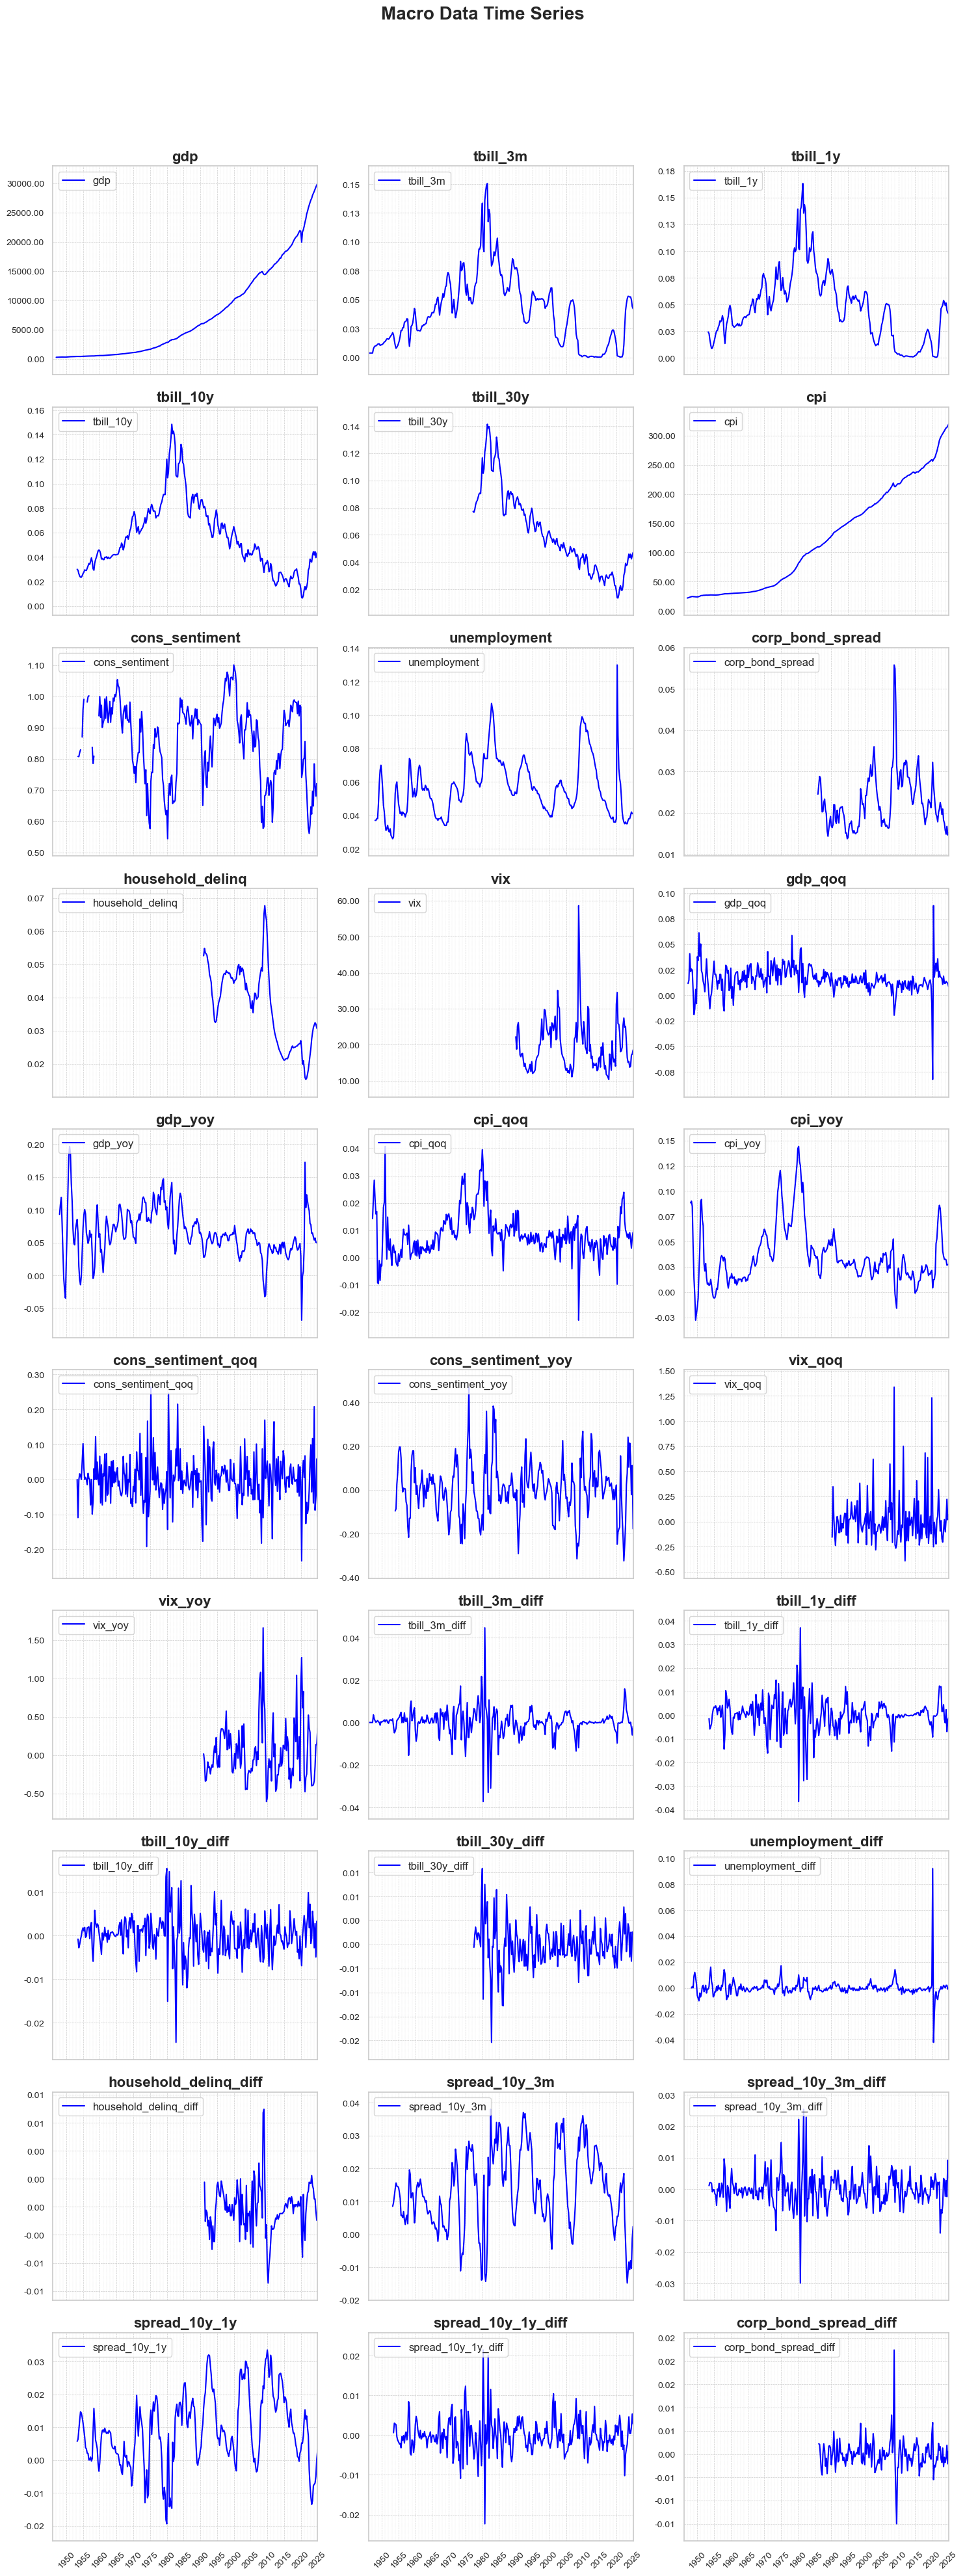

In [8]:
# Display all the columns in a separate chart (small, facetted)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import rcParams
import pandas as pd # Ensure pandas is imported if not already

# Set the style
sns.set(style="whitegrid")
rcParams['figure.figsize'] = 12, 8
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
rcParams['legend.title_fontsize'] = 14
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titleweight'] = 'bold'

# Define the columns to plot (ensure all desired columns are listed)
# plot_columns = [
#     'gdp', 'gdp_qoq', 'gdp_yoy',
#     'cpi', 'cpi_qoq', 'cpi_yoy',
#     'tbill_3m', 'tbill_3m_diff',
#     'tbill_1y', 'tbill_1y_diff',
#     'tbill_10y', 'tbill_10y_diff',
#     'tbill_30y', 'tbill_30y_diff',
#     'spread_10y_3m', 'spread_10y_3m_diff',
#     'spread_10y_1y', 'spread_10y_1y_diff',
#     'unemployment', 'unemployment_diff', 'unemployment_yoy_diff',
#     'corp_bond_spread', 'corp_bond_spread_diff',
#     'cons_sentiment', 'cons_sentiment_diff', 'cons_sentiment_yoy_diff',
#     'household_delinq', 'household_delinq_diff', 'household_delinq_yoy_diff',
#     'vix' # Assuming VIX doesn't have diff/yoy_diff in this example
# ]

plot_columns = transformed_df.columns  # Get all columns from the transformed DataFrame

# Filter plot_columns to only include columns present in the dataframe
plot_columns = [col for col in plot_columns if col in transformed_df.columns]

# Create a figure with subplots
# Determine the number of rows needed
n_cols_to_plot = len(plot_columns)
n_plot_cols = 3 # Number of columns in the subplot grid
n_plot_rows = (n_cols_to_plot + n_plot_cols - 1) // n_plot_cols # Calculate rows needed

fig, axes = plt.subplots(nrows=n_plot_rows, ncols=n_plot_cols, figsize=(15, 4 * n_plot_rows), sharex=True)
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Convert PeriodIndex to TimestampIndex for plotting compatibility with mdates
plot_index = transformed_df.index

# Loop through the columns and plot each one
for i, col in enumerate(plot_columns):
    if i >= len(axes): # Avoid index out of bounds if fewer axes than columns
        break
    # Plot the data using the timestamp index
    axes[i].plot(plot_index, transformed_df[col].values, label=col, color='blue', linewidth=1.5)
    axes[i].set_title(col)
    # axes[i].set_ylabel(col) # Title is usually sufficient
    axes[i].legend(loc='upper left')

    # Format the x-axis to show yearly ticks
    axes[i].xaxis.set_major_locator(mdates.YearLocator(5)) # Show tick every 5 years
    axes[i].xaxis.set_minor_locator(mdates.YearLocator(1)) # Minor ticks every year
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)

    # Auto-adjust y-axis limits with some padding
    min_val = transformed_df[col].min()
    max_val = transformed_df[col].max()
    # Check if min/max are valid numbers and different
    if pd.notna(min_val) and pd.notna(max_val) and min_val != max_val:
        padding = (max_val - min_val) * 0.1 # 10% padding
        axes[i].set_ylim(min_val - padding, max_val + padding)
    elif pd.notna(min_val) and pd.notna(max_val): # Handle case where min == max
        axes[i].set_ylim(min_val - 0.1, max_val + 0.1) # Add small fixed padding


    # Set the y-axis to have a specific format (e.g., 2 decimal places)
    axes[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
    axes[i].tick_params(axis='y', labelsize=10)

    # Set the x-axis limits
    axes[i].set_xlim(plot_index.min(), plot_index.max())

    # Add grid lines
    axes[i].grid(True, which='major', linestyle='--', linewidth=0.5)
    axes[i].grid(True, which='minor', linestyle=':', linewidth=0.3)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Set the title for the entire figure
fig.suptitle('Macro Data Time Series', fontsize=20, fontweight='bold', y=1.02) # Adjust y position

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust rect to make space for suptitle

# Show the plot
plt.show()
